# 게임 데이터셋

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from plotnine import *
import warnings
import requests
import re
from bs4 import BeautifulSoup
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

### 사용할 데이터셋 불러오기

In [2]:
# sd is Steam Data
sd_df = pd.read_csv("AllSteamData.csv", encoding="utf-8-sig")
display(sd_df.head(5))

# sg is Steam Games
sg_df = pd.read_csv("steam_games.csv")
display(sg_df)

# gg is Game Genres
# gg_df = pd.read_csv("game_genres.csv", encoding="utf-8-sig")
# display(gg_df)

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
0,Counter-Strike,Last 30 Days,8488.74,27.6,0.33%,15065
1,Counter-Strike,Sep-21,8461.12,-390.07,-4.41%,14559
2,Counter-Strike,Aug-21,8851.19,-286.57,-3.14%,14064
3,Counter-Strike,Jul-21,9137.76,-359.69,-3.79%,14972
4,Counter-Strike,Jun-21,9497.45,-1243.5,-11.58%,16391


,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats","English,Korean,Simplified Chinese,French,Germa...",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","English,German,Russian,French",NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40828,https://store.steampowered.com/app/899836/Rock...,app,Rocksmith® 2014 Edition – Remastered – Sabaton...,NaN,NaN,NaN,"Feb 12, 2019",Ubisoft - San Francisco,NaN,"Casual,Simulation","Single-player,Shared/Split Screen,Downloadable...","English,German,French,Italian,Spanish - Spain,...",NaN,"Casual,Simulation","About This Content Play ""Ghost Division"" by S...",NaN,"Minimum:,OS:,Windows Vista, Windows 7, Windows...","Recommended:,OS:,Windows Vista, Windows 7,

---

### 분석에 사용될 게임 목록 구하기

In [3]:
# 최소 충분 개월수를 구하여 위의 목록 중 데이터 표본이 적어 분석에 부적합한(코로나 전/후로 나눌 수 없는) 게임 제거

""" 데이터 부족하다고 느낄 시 개월수 줄여보기 (최소 36) """
first_outbreak = datetime(2019, 12, 1)
latest_month = sd_df[["Month"]].max()["Month"] # 2021-09
latest_datetime = datetime(2021, 9, 1)

num_month = (latest_datetime.year - first_outbreak.year) * 12 + (latest_datetime.month - first_outbreak.month)
min_month = num_month * 2 # 현재와 코로나 19 최초 발견 사이의 개월수의 두배에 달하는 개월수를 적정 표본 수로 규정
                          # 즉, 해당 숫자보다 적은 행을 갖는 게임은 코로나 전후에 따른 추이를 분석하기에 불충분한 데이터로 판단
starting_point = datetime(latest_datetime.year - (min_month // 12), latest_datetime.month - (min_month % 12), 1).strftime("%Y-%m")
print(f"최소 충분 개월수: {min_month}")
print(f"분석 시작 기간: {starting_point}")

최소 충분 개월수: 42
분석 시작 기간: 2018-03


In [4]:
# 열 이름 수정
sd_df.columns = ["name", "month", "avg_players", "gain", "gain_percentage", "peak_players"]

display(sd_df)

,name,month,avg_players,gain,gain_percentage,peak_players
0,Counter-Strike,Last 30 Days,8488.74,27.6,0.33%,15065
1,Counter-Strike,Sep-21,8461.12,-390.07,-4.41%,14559
2,Counter-Strike,Aug-21,8851.19,-286.57,-3.14%,14064
3,Counter-Strike,Jul-21,9137.76,-359.69,-3.79%,14972
4,Counter-Strike,Jun-21,9497.45,-1243.5,-11.58%,16391
...,...,...,...,...,...,...
878170,Ultra Age Demo,Last 30 Days,5.45,NaN,NaN,35
878171,Grim Tales: Crimson Hollow Collector's Edition,Last 30 Days,2.40,NaN,NaN,9
878172,Everyday Life in Hospital VR,Last 30 Days,0.00,NaN,NaN,0
878173,Martha Is Dead Demo,Last 30 Days,9.03,NaN,NaN,41


In [5]:
# 불필요한 행(Last 30 Days) 제거
sd_df = sd_df.drop(sd_df[sd_df["month"] == "Last 30 Days"].index)

display(sd_df)

,name,month,avg_players,gain,gain_percentage,peak_players
1,Counter-Strike,Sep-21,8461.12,-390.07,-4.41%,14559
2,Counter-Strike,Aug-21,8851.19,-286.57,-3.14%,14064
3,Counter-Strike,Jul-21,9137.76,-359.69,-3.79%,14972
4,Counter-Strike,Jun-21,9497.45,-1243.5,-11.58%,16391
5,Counter-Strike,May-21,10740.95,-1685.32,-13.56%,18089
...,...,...,...,...,...,...
877907,我的侠客 试玩版,Sep-21,21.66,-,-,83
877912,The Planet Crafter Demo,Sep-21,35.16,-,-,114
878062,Haunted Hotel: The Axiom Butcher Collector's E...,Sep-21,3.32,-,-,8
878078,Karryn's Prison Demo,Sep-21,3.98,-,-,9


In [6]:
# 시계열 데이터 처리
sd_df["month"] = sd_df[["month"]].apply(
    lambda x: datetime.strptime(x["month"], "%b-%y").strftime("%Y-%m"), axis=1
)

display(sd_df)

,name,month,avg_players,gain,gain_percentage,peak_players
1,Counter-Strike,2021-09,8461.12,-390.07,-4.41%,14559
2,Counter-Strike,2021-08,8851.19,-286.57,-3.14%,14064
3,Counter-Strike,2021-07,9137.76,-359.69,-3.79%,14972
4,Counter-Strike,2021-06,9497.45,-1243.5,-11.58%,16391
5,Counter-Strike,2021-05,10740.95,-1685.32,-13.56%,18089
...,...,...,...,...,...,...
877907,我的侠客 试玩版,2021-09,21.66,-,-,83
877912,The Planet Crafter Demo,2021-09,35.16,-,-,114
878062,Haunted Hotel: The Axiom Butcher Collector's E...,2021-09,3.32,-,-,8
878078,Karryn's Prison Demo,2021-09,3.98,-,-,9


In [7]:
# 분석 기간에 해당하지 않는 게임 이용 시간 데이터(행) 제거
def is_not_range(month):
    if datetime.strptime(month, "%Y-%m") < datetime.strptime(starting_point, "%Y-%m"):
        return True
    else:
        return False

sd_df["not_range"] = sd_df[["month"]].apply(
    lambda x: is_not_range(x["month"]), axis = 1
)
sd_df = sd_df[sd_df["not_range"] == False].reset_index(drop=True)

display(sd_df)

,name,month,avg_players,gain,gain_percentage,peak_players,not_range
0,Counter-Strike,2021-09,8461.12,-390.07,-4.41%,14559,False
1,Counter-Strike,2021-08,8851.19,-286.57,-3.14%,14064,False
2,Counter-Strike,2021-07,9137.76,-359.69,-3.79%,14972,False
3,Counter-Strike,2021-06,9497.45,-1243.5,-11.58%,16391,False
4,Counter-Strike,2021-05,10740.95,-1685.32,-13.56%,18089,False
...,...,...,...,...,...,...,...
508765,我的侠客 试玩版,2021-09,21.66,-,-,83,False
508766,The Planet Crafter Demo,2021-09,35.16,-,-,114,False
508767,Haunted Hotel: The Axiom Butcher Collector's E...,2021-09,3.32,-,-,8,False
508768,Karryn's Prison Demo,2021-09,3.98,-,-,9,False


In [8]:
# 개월수가 충족되지 않은 불충분 데이터 제거
gl_df = sd_df.groupby("name").count().reset_index()[["name", "month"]]
gl_df.columns = ["name", "number_of_data"]
gl_df = gl_df[gl_df["number_of_data"] >= min_month].reset_index(drop=True)

sd_df = sd_df[sd_df["name"].isin(list(gl_df["name"]))].reset_index(drop=True)

display(sd_df)

,name,month,avg_players,gain,gain_percentage,peak_players,not_range
0,Counter-Strike,2021-09,8461.12,-390.07,-4.41%,14559,False
1,Counter-Strike,2021-08,8851.19,-286.57,-3.14%,14064,False
2,Counter-Strike,2021-07,9137.76,-359.69,-3.79%,14972,False
3,Counter-Strike,2021-06,9497.45,-1243.5,-11.58%,16391,False
4,Counter-Strike,2021-05,10740.95,-1685.32,-13.56%,18089,False
...,...,...,...,...,...,...,...
218085,Evolution,2021-01,1.84,-1.5,-44.87%,6,False
218086,Evolution,2020-12,3.34,-5.78,-63.39%,13,False
218087,Evolution,2020-11,9.13,-,-,32,False
218088,Ascension,2021-06,0.82,0.04,5.64%,3,False


---

### 게임 목록을 바탕으로 데이터 전처리

In [9]:
# Avg. Players 열의 백분율 수치 추가
# mp is Max Players
mp_df = sd_df.groupby("name").max().reset_index()[["name", "avg_players"]]
mp_df.columns = ["name", "max_players"]

# Max Player 행 추가
sd_df = pd.merge(sd_df, mp_df, on="name", how="inner")

# 최대 플레이어 수를 100으로 뒀을 때의 수치를 계산하여 avg_players 열의 백분율 수치 추가(!!백분율로 사용한 게 잘못된거 같음!!)
sd_df["avg_players_percentage"] = sd_df[["avg_players", "max_players"]].apply(
    lambda x: x["avg_players"] / x["max_players"] * 100 if x["max_players"] != 0 else np.nan, axis=1
)

display(sd_df)

,name,month,avg_players,gain,gain_percentage,peak_players,not_range,max_players,avg_players_percentage
0,Counter-Strike,2021-09,8461.12,-390.07,-4.41%,14559,False,17764.58,47.629159
1,Counter-Strike,2021-08,8851.19,-286.57,-3.14%,14064,False,17764.58,49.824933
2,Counter-Strike,2021-07,9137.76,-359.69,-3.79%,14972,False,17764.58,51.438086
3,Counter-Strike,2021-06,9497.45,-1243.5,-11.58%,16391,False,17764.58,53.462846
4,Counter-Strike,2021-05,10740.95,-1685.32,-13.56%,18089,False,17764.58,60.462730
...,...,...,...,...,...,...,...,...,...
218085,DeoVR Video Player,2018-08,8.24,0.48,6.19%,20,False,76.40,10.785340
218086,DeoVR Video Player,2018-07,7.76,1.46,23.12%,18,False,76.40,10.157068
218087,DeoVR Video Player,2018-06,6.30,0.98,18.47%,17,False,76.40,8.246073
218088,DeoVR Video Player,2018-05,5.32,1.82,51.89%,13,False,76.40,6.963351


In [10]:
# gain_percentage로 부터 증감율 계산
def convert_minus_str(gain_percentage):
    if "%" in gain_percentage:
        if "-" in gain_percentage.replace("%", ""):
            return -1 * float(gain_percentage[1:-2])
        elif "NaN" in gain_percentage or "Inf" in gain_percentage:
            return np.nan
        else:
            return float(gain_percentage[0:-2])
    else:
        return 0
    
sd_df["rate_of_change"] = sd_df[["gain_percentage"]].apply(
    lambda x: 1 + 0.01 * convert_minus_str(x["gain_percentage"]), axis = 1
)

display(sd_df)

,name,month,avg_players,gain,gain_percentage,peak_players,not_range,max_players,avg_players_percentage,rate_of_change
0,Counter-Strike,2021-09,8461.12,-390.07,-4.41%,14559,False,17764.58,47.629159,0.956
1,Counter-Strike,2021-08,8851.19,-286.57,-3.14%,14064,False,17764.58,49.824933,0.969
2,Counter-Strike,2021-07,9137.76,-359.69,-3.79%,14972,False,17764.58,51.438086,0.963
3,Counter-Strike,2021-06,9497.45,-1243.5,-11.58%,16391,False,17764.58,53.462846,0.885
4,Counter-Strike,2021-05,10740.95,-1685.32,-13.56%,18089,False,17764.58,60.462730,0.865
...,...,...,...,...,...,...,...,...,...,...
218085,DeoVR Video Player,2018-08,8.24,0.48,6.19%,20,False,76.40,10.785340,1.061
218086,DeoVR Video Player,2018-07,7.76,1.46,23.12%,18,False,76.40,10.157068,1.231
218087,DeoVR Video Player,2018-06,6.30,0.98,18.47%,17,False,76.40,8.246073,1.184
218088,DeoVR Video Player,2018-05,5.32,1.82,51.89%,13,False,76.40,6.963351,1.518


In [11]:
# 미사용 열 제거 및 열 정렬
sd_df = sd_df.drop(["not_range", "peak_players", "max_players"], axis=1)
sd_df.columns = ["name", "month", "avg_players", "avg_players_percentage", "gain", "gain_percentage", "rate_of_change"]

display(sd_df)

,name,month,avg_players,avg_players_percentage,gain,gain_percentage,rate_of_change
0,Counter-Strike,2021-09,8461.12,-390.07,-4.41%,47.629159,0.956
1,Counter-Strike,2021-08,8851.19,-286.57,-3.14%,49.824933,0.969
2,Counter-Strike,2021-07,9137.76,-359.69,-3.79%,51.438086,0.963
3,Counter-Strike,2021-06,9497.45,-1243.5,-11.58%,53.462846,0.885
4,Counter-Strike,2021-05,10740.95,-1685.32,-13.56%,60.462730,0.865
...,...,...,...,...,...,...,...
218085,DeoVR Video Player,2018-08,8.24,0.48,6.19%,10.785340,1.061
218086,DeoVR Video Player,2018-07,7.76,1.46,23.12%,10.157068,1.231
218087,DeoVR Video Player,2018-06,6.30,0.98,18.47%,8.246073,1.184
218088,DeoVR Video Player,2018-05,5.32,1.82,51.89%,6.963351,1.518


In [12]:
# 게임별 평균 이용자 수 증감율(기하 평균) 계산
gl_df["geom_avg"] = 0

for i, name in enumerate(list(gl_df["name"])):     
    # sa is Single App
    sa_df = sd_df[sd_df["name"] == name].copy()
    roc_list = list(sa_df["rate_of_change"])
    geom_avg = reduce(lambda x, y: x * y, roc_list) ** (1/len(roc_list)) # 기하 평균
    
    gl_df.loc[gl_df["name"] == name, "geom_avg"] = geom_avg
    
display(gl_df)

,name,number_of_data,geom_avg
0,"!""We Are The Dwarves""!",42,1.046005
1,#killallzombies,43,1.005320
2,#monstercakes,43,0.980555
3,- Arcane RERaise -,43,1.091448
4,- Arcane preRaise -,43,1.064363
...,...,...,...
5055,東方天空璋 ～ Hidden Star in Four Seasons.,43,0.967514
5056,東方憑依華 ～ Antinomy of Common Flowers.,43,0.947584
5057,永遠消失的幻想鄉 ～ The Disappearing of Gensokyo,43,0.922289
5058,神舞幻想 Faith of Danschant,43,0.990913


In [13]:
# 코로나 이후 평균 이용자수 증가 추세 여부
def is_before_after(month):
    if datetime.strptime(month, "%Y-%m") >= datetime(2019, 12, 1): # first_outbreak
        return "after corona"
    else:
        return "before corona"
    
sd_df["period"] = sd_df[["month"]].apply(
    lambda x: is_before_after(x["month"]), axis=1
)

# ba is Before & After
ba_df = sd_df[["name", "avg_players", "period"]].groupby(["name", "period"]).sum().reset_index()
display(ba_df.head(10))

# '코로나 특수' 용어..?
def is_corona_special(tmp_df):
    if tmp_df.iloc[0, 2] > tmp_df.iloc[1, 2]: # 코로나 이후 평균 이용자 수가 코로나 이전보다 크다면
        return True                           # 해당 게임에 '코로나 특수'가 존재했다
    else:
        return False
    
gl_df["corona_special"] = gl_df[["name"]].apply(
    lambda x: is_corona_special(ba_df[ba_df["name"] == x["name"]]), axis = 1
)

display(gl_df)

,name,period,avg_players
0,"!""We Are The Dwarves""!",after corona,37.61
1,"!""We Are The Dwarves""!",before corona,80.47
2,#killallzombies,after corona,104.20
3,#killallzombies,before corona,67.15
4,#monstercakes,after corona,583.05
5,#monstercakes,before corona,958.64
6,- Arcane RERaise -,after corona,1020.95
7,- Arcane RERaise -,before corona,920.72
8,- Arcane preRaise -,after corona,1529.66
9,- Arcane preRaise -,before corona,1485.37


,name,number_of_data,geom_avg,corona_special
0,"!""We Are The Dwarves""!",42,1.046005,False
1,#killallzombies,43,1.005320,True
2,#monstercakes,43,0.980555,False
3,- Arcane RERaise -,43,1.091448,True
4,- Arcane preRaise -,43,1.064363,True
...,...,...,...,...
5055,東方天空璋 ～ Hidden Star in Four Seasons.,43,0.967514,False
5056,東方憑依華 ～ Antinomy of Common Flowers.,43,0.947584,False
5057,永遠消失的幻想鄉 ～ The Disappearing of Gensokyo,43,0.922289,False
5058,神舞幻想 Faith of Danschant,43,0.990913,True


In [14]:
# 미사용 행 제거(gl_df)
gl_df = gl_df.drop(["number_of_data"], axis = 1)

display(gl_df)

,name,geom_avg,corona_special
0,"!""We Are The Dwarves""!",1.046005,False
1,#killallzombies,1.005320,True
2,#monstercakes,0.980555,False
3,- Arcane RERaise -,1.091448,True
4,- Arcane preRaise -,1.064363,True
...,...,...,...
5055,東方天空璋 ～ Hidden Star in Four Seasons.,0.967514,False
5056,東方憑依華 ～ Antinomy of Common Flowers.,0.947584,False
5057,永遠消失的幻想鄉 ～ The Disappearing of Gensokyo,0.922289,False
5058,神舞幻想 Faith of Danschant,0.990913,True


In [15]:
gl_df.to_csv("gl_df.csv", encoding="utf-8-sig", index=False)

In [15]:
sg_df = pd.read_csv("steam_games.csv")
# 분석에 사용될 게임 목록으로 데이터 한정, 이 때 원본 sg_df에 존재하지 않는 gl_df의 게임들은 추후에 추가 스크래핑 필요
#                                                                           gl_df[~gl_df["name"].isin(list(sg_df["name"]))])

sg_df = sg_df[sg_df["name"].isin(list(gl_df["name"]))].reset_index(drop=True)

display(sg_df.shape)
display(sg_df.head(3))

(3254, 20)

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN
2,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN


In [16]:
# url 열로 부터 app_id 추출
def get_app_id(url):
    pattern = "app/(.+?)/"
    result = re.search(pattern, url)
    if result:
        return result.group(1)
    else:
        # bundle app의 경우 url 패턴이 달라 app_id 대신 None이 리턴됨 
        return None

sg_df["app_id"] = sg_df[["url"]].apply(
    lambda x: get_app_id(x["url"]), axis = 1
)

display(sg_df.head(3))

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,app_id
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,"English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,379720
1,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,"English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,637090
2,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,"English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,221100


In [17]:
# publisher 열 정규화
def normalize_publisher(publisher):
    if isinstance(publisher, str):
        return publisher.split(",")[0]

sg_df["publisher"] = sg_df[["publisher"]].apply(
    lambda x: normalize_publisher(x["publisher"]), axis = 1
)

display(sg_df.head(3))

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,app_id
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,Bethesda Softworks,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,"English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,379720
1,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,Paradox Interactive,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,"English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,637090
2,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,Bohemia Interactive,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,"English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,221100


In [18]:
# origianl_prcie 정규화
def normalize_price(original_price):
    if "$" in str(original_price):
        return original_price.replace("$", "")
    elif original_price == "Free":
        return "0"
    else:
        return 0
    
sg_df["price"] = sg_df[["original_price"]].apply(
    lambda x: normalize_price(x["original_price"]), axis = 1
)
sg_df.astype({"price": np.float64})

display(sg_df.head(3))

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,app_id,price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,Bethesda Softworks,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,379720,19.99
1,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,Paradox Interactive,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,637090,39.99
2,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,Bohemia Interactive,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,221100,44.99


In [19]:
# 코옵(Co-op) 지향 여부
def is_coop(game_details):
    if "co-op" in str(game_details).lower():
        return True
    else:
        return False
    
sg_df["co-op"] = sg_df[["game_details"]].apply(
    lambda x: is_coop(x["game_details"]), axis = 1
)

display(sg_df.head(3))

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,app_id,price,co-op
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,Bethesda Softworks,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,379720,19.99,True
1,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,Paradox Interactive,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,637090,39.99,False
2,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,Bohemia Interactive,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,221100,44.99,False


In [20]:
# 청소년 불가 판정 여부
def is_r_rated(mature_content):
    if isinstance(mature_content, float): # np.nan
        return False
    else:
        return True
    
sg_df["r_rated"] = sg_df[["mature_content"]].apply(
    lambda x: is_r_rated(x["mature_content"]), axis = 1
)

display(sg_df.head(3))

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,app_id,price,co-op,r_rated
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,Bethesda Softworks,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,379720,19.99,True,False
1,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,Paradox Interactive,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,637090,39.99,False,False
2,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,Bohemia Interactive,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,221100,44.99,False,False


In [21]:
# '사회적 게임' 여부 판별
# '사회적 게임'이란 생활 시뮬레이션, 스포츠 등 언택트 시대에 유의미하다고 판단되는 임의의 게임 태그들의 집합을 의미함
def is_social(popular_tags):
    # 교집합 연산을 위해 set 자료형으로 선언
    social_tags = {"Simulation", "Sandbox", "Sports"}
    popular_tags = set(str(popular_tags).split(","))
    
    if social_tags & popular_tags:
        return True
    else:
        return False
    
sg_df["is_social"] = sg_df[["popular_tags"]].apply(
    lambda x: is_social(x["popular_tags"]), axis = 1
)

display(sg_df.head(3))

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,app_id,price,co-op,r_rated,is_social
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,Bethesda Softworks,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,379720,19.99,True,False,False
1,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,Paradox Interactive,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,637090,39.99,False,False,False
2,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,Bohemia Interactive,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,221100,44.99,False,False,True


In [22]:
# 불필요한 행 정리
sg_df = sg_df[["app_id", "name", "price", "developer", "publisher", "co-op", "r_rated", "is_social"]]

display(sg_df)

,app_id,name,price,developer,publisher,co-op,r_rated,is_social
0,379720,DOOM,19.99,id Software,Bethesda Softworks,True,False,False
1,637090,BATTLETECH,39.99,Harebrained Schemes,Paradox Interactive,False,False,False
2,221100,DayZ,44.99,Bohemia Interactive,Bohemia Interactive,False,False,True
3,8500,EVE Online,0,CCP,CCP,True,False,True
4,477160,Human: Fall Flat,14.99,No Brakes Games,Curve Digital,True,False,True
...,...,...,...,...,...,...,...,...
3249,233680,Black Ink,0,Bleank,Bleank,False,False,False
3250,748890,Choice of Rebels: Uprising,501.87,Choice of Games,Choice of Games,False,False,False
3251,471810,Death Squared,14.99,SMG Studio,SMG Studio,True,False,False
3252,404590,Vikings - Wolves of Midgard,29.99,Games Farm,Kalypso Media Digital,True,False,False


### 데이터 병합
데이터가 존재하는 게임에 한하여 먼저 병합, 추후에 스크래핑 필요

In [23]:
# red, white 데이터셋에 대한 모형에 착안하여, 모형을 만들 실제 데이터셋의 미완성 단계 해당함
# red - white로 나뉘는 기준을 is_social = True - is_social = False로 나눠서 모형 제작 시도 예정
# tg is target
tg_df = pd.merge(sg_df, gl_df, how="inner", on="name")

display(tg_df)

,app_id,name,price,developer,publisher,co-op,r_rated,is_social,geom_avg,corona_special
0,379720,DOOM,19.99,id Software,Bethesda Softworks,True,False,False,0.990555,True
1,637090,BATTLETECH,39.99,Harebrained Schemes,Paradox Interactive,False,False,False,1.146594,False
2,221100,DayZ,44.99,Bohemia Interactive,Bohemia Interactive,False,False,True,1.053440,True
3,8500,EVE Online,0,CCP,CCP,True,False,True,1.002647,True
4,477160,Human: Fall Flat,14.99,No Brakes Games,Curve Digital,True,False,True,0.989966,True
...,...,...,...,...,...,...,...,...,...,...
3249,233680,Black Ink,0,Bleank,Bleank,False,False,False,0.984097,True
3250,748890,Choice of Rebels: Uprising,501.87,Choice of Games,Choice of Games,False,False,False,0.973015,False
3251,471810,Death Squared,14.99,SMG Studio,SMG Studio,True,False,False,1.031506,True
3252,404590,Vikings - Wolves of Midgard,29.99,Games Farm,Kalypso Media Digital,True,False,False,0.987455,False


### 시각화

In [24]:
# 소셜 게임과 비 소셜 게임의 두그룹으로 시각화할 수 있도록 데이터 처리
# sc is social
sc_df = sd_df[sd_df["name"].isin(tg_df[tg_df["is_social"] == True].loc[:, "name"]) == True]
display(sc_df)

,name,month,avg_players,avg_players_percentage,gain,gain_percentage,rate_of_change,period
215,Ricochet,2021-09,4.49,-0.07,-1.51%,42.238946,0.985,after corona
216,Ricochet,2021-08,4.56,-2,-30.49%,42.897460,0.696,after corona
217,Ricochet,2021-07,6.56,-0.35,-5.12%,61.712135,0.949,after corona
218,Ricochet,2021-06,6.91,1.72,33.10%,65.004704,1.331,after corona
219,Ricochet,2021-05,5.19,-0.14,-2.60%,48.824083,0.974,after corona
...,...,...,...,...,...,...,...,...
217984,Hiveswap Friendsim,2018-08,23.73,1.24,5.52%,57.084436,1.055,before corona
217985,Hiveswap Friendsim,2018-07,22.49,-1.34,-5.60%,54.101516,0.944,before corona
217986,Hiveswap Friendsim,2018-06,23.83,5.96,33.33%,57.324994,1.333,before corona
217987,Hiveswap Friendsim,2018-05,17.87,-10.86,-37.79%,42.987732,0.623,before corona


In [25]:
# ns is non-social
ns_df = sd_df[sd_df["name"].isin(tg_df[tg_df["is_social"] == False].loc[:, "name"]) == True]
display(ns_df)

,name,month,avg_players,avg_players_percentage,gain,gain_percentage,rate_of_change,period
0,Counter-Strike,2021-09,8461.12,-390.07,-4.41%,47.629159,0.956,after corona
1,Counter-Strike,2021-08,8851.19,-286.57,-3.14%,49.824933,0.969,after corona
2,Counter-Strike,2021-07,9137.76,-359.69,-3.79%,51.438086,0.963,after corona
3,Counter-Strike,2021-06,9497.45,-1243.5,-11.58%,53.462846,0.885,after corona
4,Counter-Strike,2021-05,10740.95,-1685.32,-13.56%,60.462730,0.865,after corona
...,...,...,...,...,...,...,...,...
218085,DeoVR Video Player,2018-08,8.24,0.48,6.19%,10.785340,1.061,before corona
218086,DeoVR Video Player,2018-07,7.76,1.46,23.12%,10.157068,1.231,before corona
218087,DeoVR Video Player,2018-06,6.30,0.98,18.47%,8.246073,1.184,before corona
218088,DeoVR Video Player,2018-05,5.32,1.82,51.89%,6.963351,1.518,before corona


In [26]:
sc_df = sc_df.groupby("month").sum().reset_index()
sc_df.head(5)

,month,avg_players,gain_percentage,rate_of_change
0,2018-03,1126150.77,64868.572801,4410.062
1,2018-04,1110378.82,61209.657603,64261.920
2,2018-05,1166639.28,59141.936397,46553.751
3,2018-06,1209576.80,62751.720600,1344.936
4,2018-07,1238920.43,63660.404237,1284.398


In [27]:
ns_df = ns_df.groupby("month").sum().reset_index()
ns_df.tail()

,month,avg_players,gain_percentage,rate_of_change
38,2021-05,1282228.83,89839.829147,2307.754
39,2021-06,1143818.65,90068.961699,2379.499
40,2021-07,1154186.08,97246.262377,2346.024
41,2021-08,1126029.51,87948.767890,2003.046
42,2021-09,1076395.14,83364.850236,2286.344


In [28]:
sc_df = sc_df[["month", "avg_players"]]
sc_df.columns = ["Month", "Social Games"]

ns_df = ns_df[["month", "avg_players"]]
ns_df.columns = ["Month", "Non-Social Games"]

# fg is For Graph
fg_df = pd.merge(sc_df, ns_df, how = "inner", on = "Month")

display(fg_df)

,Month,Social Games,Non-Social Games
0,2018-03,1126150.77,881083.15
1,2018-04,1110378.82,760203.91
2,2018-05,1166639.28,699284.53
3,2018-06,1209576.80,779501.87
4,2018-07,1238920.43,792302.83
5,2018-08,1180230.58,720378.90
6,2018-09,1075759.11,760889.04
7,2018-10,1029577.04,742389.98
8,2018-11,1103003.45,751349.17
9,2018-12,1157137.56,886260.21


In [29]:
sc_max = fg_df.max()["Social Games"]
ns_max = fg_df.max()["Non-Social Games"]

fg_df["Social Games"] = fg_df[["Social Games"]].apply(
    lambda x: x["Social Games"] / sc_max * 100, axis=1
)

fg_df["Non-Social Games"] = fg_df[["Non-Social Games"]].apply(
    lambda x: x["Non-Social Games"] / ns_max * 100, axis=1
)

display(fg_df)

,Month,Social Games,Non-Social Games
0,2018-03,68.494193,58.622134
1,2018-04,67.534919,50.579534
2,2018-05,70.956766,46.526314
3,2018-06,73.568290,51.863508
4,2018-07,75.353014,52.715209
5,2018-08,71.783409,47.929810
6,2018-09,65.429296,50.625119
7,2018-10,62.620433,49.394299
8,2018-11,67.086338,49.990391
9,2018-12,70.378857,58.966585


[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Avg. Users(%)'),
 Text(0.5, 1.0, '소셜 게임과 비 소셜 게임의 월별 이용자 평균 변화 추이')]

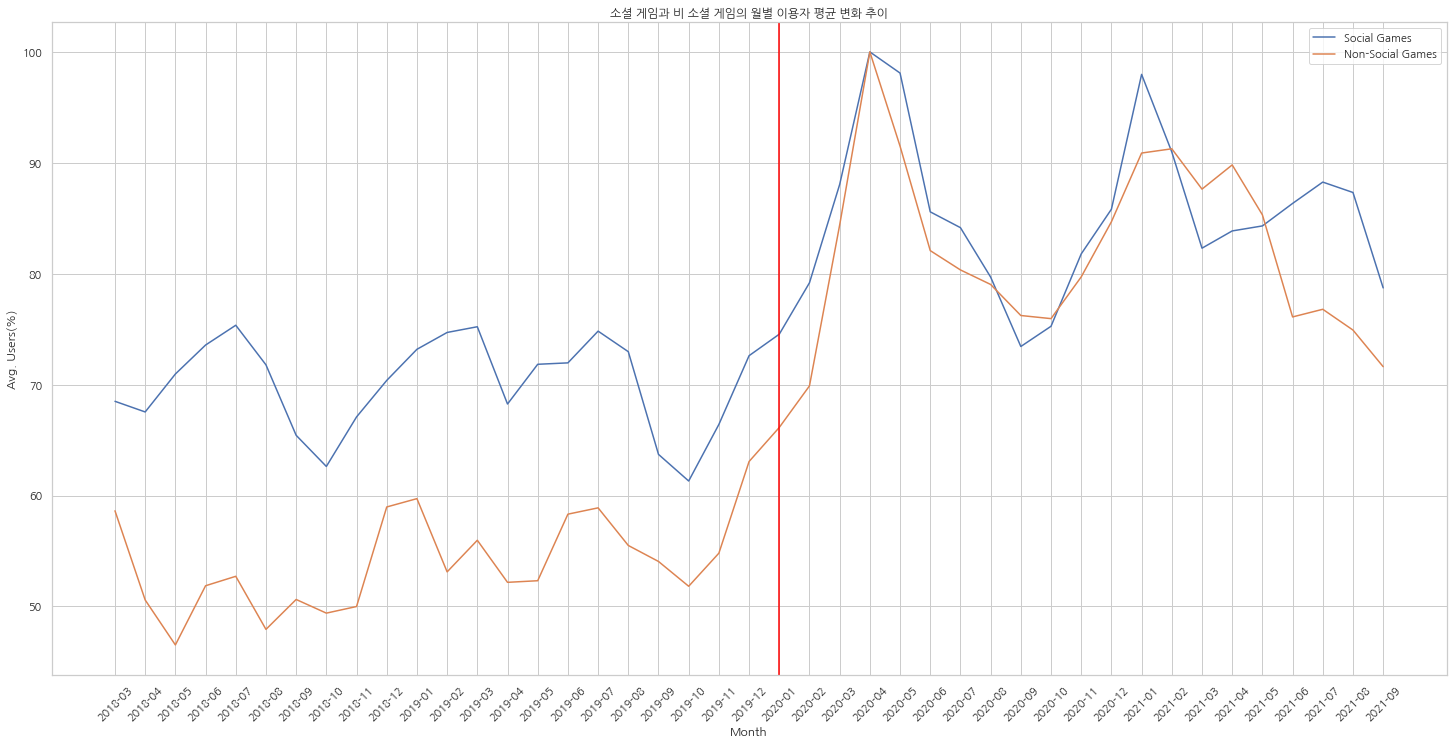

In [30]:
sns.set(rc = {'figure.figsize':(25,12)})
sns.set_style('whitegrid')
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc("font", family = "NanumGothic")


ax = sns.lineplot(x = "Month", y = "Social Games", data = fg_df)
ax = sns.lineplot(x = "Month", y = "Non-Social Games", data = fg_df)
plt.xticks(rotation=45)
plt.axvline(22, 0, 1, color="red")

plt.legend(labels=["Social Games", "Non-Social Games"])
ax.set(xlabel = "Month", ylabel = "Avg. Users(%)", title = "소셜 게임과 비 소셜 게임의 월별 이용자 평균 변화 추이")

### 느낀점
코로나가 전세계적으로 인지되며 사람들이 주의하기 시작한 2020년 초 부터 상반기 동안은 이용자 수의 폭발적인 증가가 있지만 코로나에 대한 인식 변화, 거리두기 단계 조정, 백신 접종 등의 이유로 상승세는 유지되지 못하였다. 코로나 데이터 셋과 합쳐서 분석 시 위에 언급한 사실에 기사 검색 등의 자료를 보충하여 설명하면 설득력을 얻을 수 있어보인다. 이는 코로나 데이터 셋과 나란히 비교하여 명확한 결론을 고안해보는 방향으로 이어지게 될 것 같다. 또한 단순히 스팀에서 제공하는 게임 장르를 통해 분류하여 얻은 그래프는 명확한 결과를 보여주지 못하였다. 따라서 <u>(1) tg_df의 게임들을 일일히 확인하거나</u> <u>(2) co-op 게임과 비 co-op 게임으로 나누거나</u> <u>(3) 전체 게임 이용자수 그래프와 코로나 그래프를 발표 도입부에만 사용하고, column들은 모델을 만드는 것에만 사용하는 방법</u>이 있다.

### (1)

In [31]:
#

---
### (2)

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Avg. Users(%)'),
 Text(0.5, 1.0, '코옵 게임과 비 코옵 게임의 월별 이용자 평균 변화 추이')]

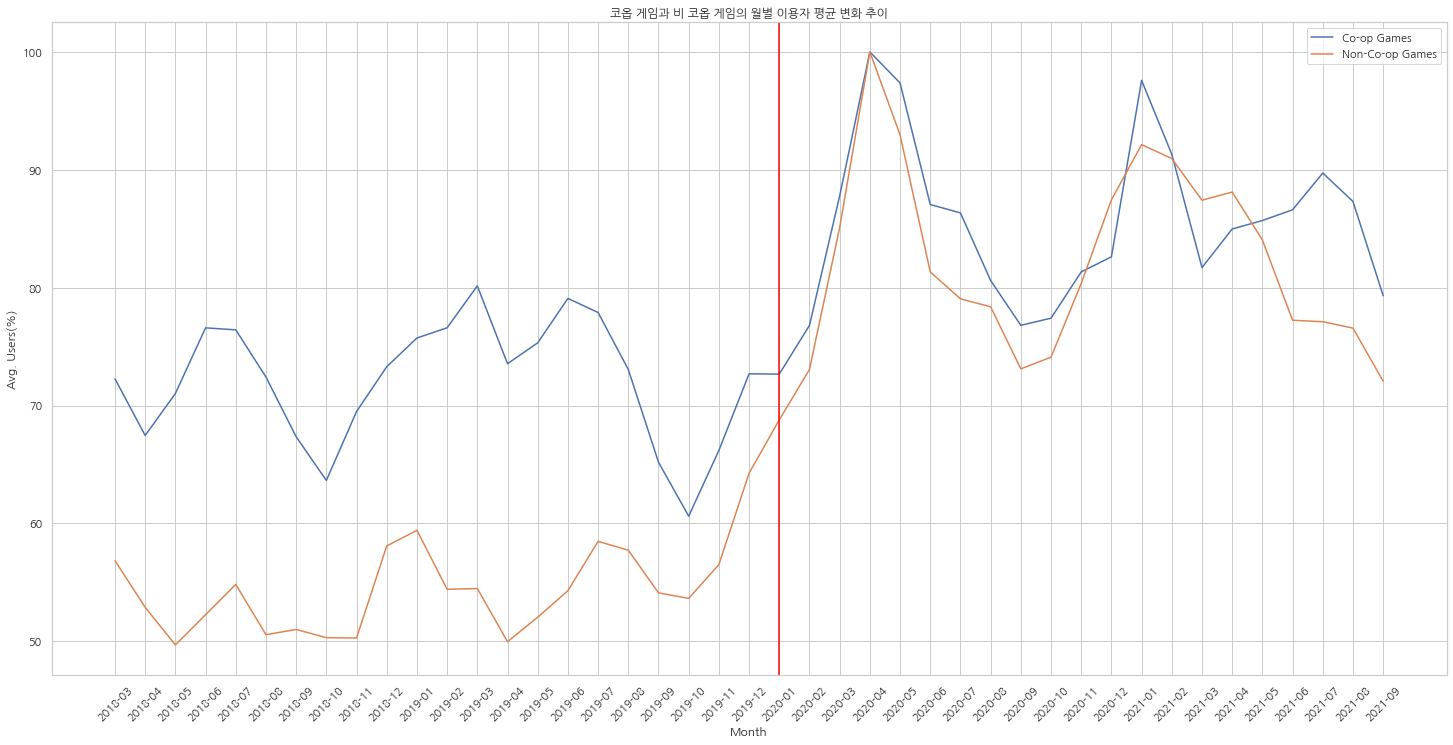

In [32]:
co_df = sd_df[sd_df["name"].isin(tg_df[tg_df["co-op"] == True].loc[:, "name"]) == True]
no_df = sd_df[sd_df["name"].isin(tg_df[tg_df["co-op"] == False].loc[:, "name"]) == True]

co_df = co_df.groupby("month").sum().reset_index()
no_df = no_df.groupby("month").sum().reset_index()

co_df = co_df[["month", "avg_players"]]
co_df.columns = ["Month", "Co-op Games"]

no_df = no_df[["month", "avg_players"]]
no_df.columns = ["Month", "Non-Co-op Games"]

# fg is For Graph
fg2_df = pd.merge(co_df, no_df, how = "inner", on = "Month")

co_max = fg2_df.max()["Co-op Games"]
no_max = fg2_df.max()["Non-Co-op Games"]

fg2_df["Co-op Games"] = fg2_df[["Co-op Games"]].apply(
    lambda x: x["Co-op Games"] / co_max * 100, axis=1
)

fg2_df["Non-Co-op Games"] = fg2_df[["Non-Co-op Games"]].apply(
    lambda x: x["Non-Co-op Games"] / no_max * 100, axis=1
)

ax = sns.lineplot(x = "Month", y = "Co-op Games", data = fg2_df)
ax = sns.lineplot(x = "Month", y = "Non-Co-op Games", data = fg2_df)
plt.xticks(rotation=45)
plt.axvline(22, 0, 1, color="red")

plt.legend(labels=["Co-op Games", "Non-Co-op Games"])
ax.set(xlabel = "Month", ylabel = "Avg. Users(%)", title = "코옵 게임과 비 코옵 게임의 월별 이용자 평균 변화 추이")

마찬가지로 단순히 코옵 지향 여부에 따라 나누는 것도 정확한 결과를 가져오지 못하였다.

---
### (3)

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Avg. Users(%)'),
 Text(0.5, 1.0, '전체 게임 이용자수 추이')]

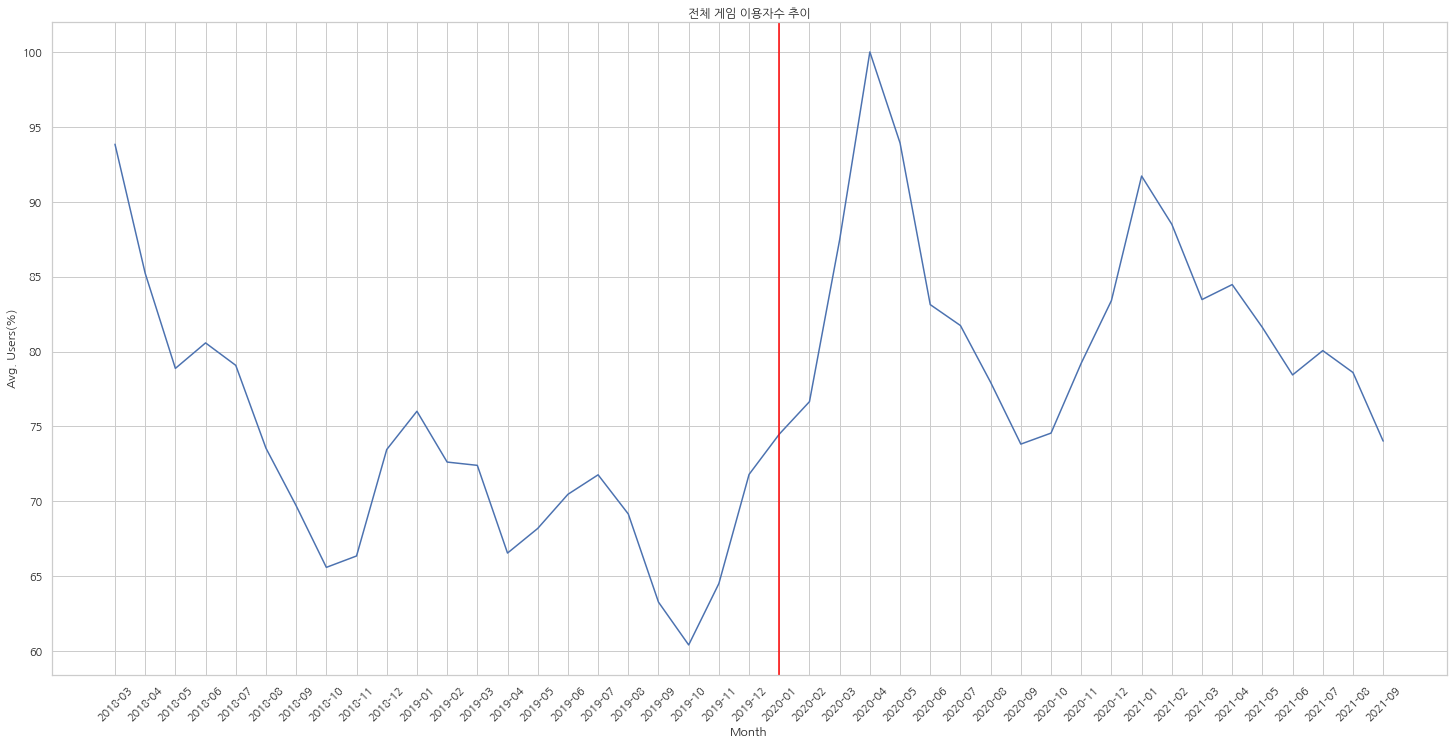

In [33]:
fg3_df = sd_df.groupby("month").sum().reset_index()
fg3_df = fg3_df[["month", "avg_players"]]
fg3_df.columns = ["Month", "Ratio of Player"]

fg3_max = fg3_df.max()["Ratio of Player"]

fg3_df["Ratio of Player"] = fg3_df[["Ratio of Player"]].apply(
    lambda x: x["Ratio of Player"] / fg3_max * 100, axis=1
)

ax = sns.lineplot(x = "Month", y = "Ratio of Player", data = fg3_df)
plt.xticks(rotation=45)
plt.axvline(22, 0, 1, color="red")

# plt.legend(labels=["Co-op Games", "Non-Co-op Games"])
ax.set(xlabel = "Month", ylabel = "Avg. Users(%)", title = "전체 게임 이용자수 추이")